## Step1. 載入訓練資料

In [1]:
import torchvision
from torchvision.io import ImageReadMode
from torchvision import transforms

import matplotlib.pyplot as plt
import random
import os, glob

IMAG_SIZE = (128, 128)
FACTOR = 4
RNN_LAYERS = 2
SEQ_SIZE = IMAG_SIZE[0] // FACTOR
INPUT_SIZE = IMAG_SIZE[1] * FACTOR
OUTPUT_SIZE = IMAG_SIZE[1] * 4

TRAIN_DIR = "train"
TEST_DIR = "test"

class LazyLoader:
    def __init__(self, base_path=None):
        self.task = list()
        self.done = list()
        self.size = 0

        self.t = transforms.Compose([
            transforms.Resize(size=IMAG_SIZE)
        ])

        if not base_path is None:
            for png_path in glob.glob(os.path.join(base_path, "*.png")):
                filename_without_postfix = png_path[:-4]
                base_path = filename_without_postfix
                txt_path = "{}.txt".format(filename_without_postfix)
                self.done.append((png_path, txt_path, base_path))
                self.size += 1

    def reset(self):
        while len(self.task) > 0:
            self.done.append(self.task.pop())

    def split(self, r = 0.1):
        self.reset()

        random.shuffle(self.task)
        split_size = round(r * len(self.done))
        split_buf = self.done[:split_size]
        self.done = self.done[split_size:]
        self.size = len(self.done)

        split_loader = LazyLoader()
        split_loader.done = split_buf
        split_loader.size = len(split_loader.done)
        return split_loader

    def look(self, batches):
        for i in range(batches):
            img, tgt, _ = self.load_data()
            plt.imshow(img.permute(1, 2, 0))
            plt.title("number {}".format(tgt))
            plt.show()

    def load_data(self):
        if len(self.task) == 0:
            self.task, self.done = self.done, self.task
            random.shuffle(self.task)

        query = self.task.pop()
        self.done.append(query)
        png_path, txt_path, base_path = query

        img = torchvision.io.read_image(png_path, mode=ImageReadMode.GRAY)
        img = img.float() / 255.
        img = self.t(img)

        try:
            with open(txt_path, "r") as f:
                tgt = int(f.read().strip().split()[0])
        except:
            tgt = -1

        return img, tgt, base_path

    def sample(self, batches):
        imgs, tgts, paths = list(), list(), list()
        for i in range(batches):
            img, tgt, path = self.load_data()
            imgs.append(img)
            tgts.append(tgt)
            paths.append(path)
        return torch.stack(imgs).float(), torch.as_tensor(tgts).long(), paths

    def __len__(self):
        return self.size

    def __iter__(self):
        self.reset()
        self.iter_index = 0
        return self
        
    def __next__(self):
        imgs, tgts, paths = self.sample(1)
        if self.size > self.iter_index:
            self.iter_index += 1
            return imgs, tgts, paths
        else:
            raise StopIteration

t_loader = LazyLoader(TRAIN_DIR) # 訓練集
v_loader = t_loader.split(0.1) # 驗證集

## Step2. 建構網路

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class Network(nn.Module):
    def __init__(self, bone):
        super().__init__()
        self.imag_size = IMAG_SIZE
        self.seq_size = SEQ_SIZE
        self.input_size = INPUT_SIZE
        self.output_size = OUTPUT_SIZE
        self._droprate = 0.1

        self.bone = bone

        self.gate = nn.Sequential(
            FullyConnect(self.output_size, 1024, nn.SiLU()),
            nn.Dropout(self._droprate),
            FullyConnect(1024, 256, nn.SiLU()),
            FullyConnect(256, 1, nn.Sigmoid())
        )
        self.head = nn.Sequential(
            FullyConnect(self.output_size, 256, nn.SiLU()),
            nn.Dropout(self._droprate),
            FullyConnect(256, 10)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        n, _, _, _ = x.shape
        inputs = torch.reshape(x, (n, self.seq_size, self.input_size))
        inputs = torch.permute(inputs, (1, 0, 2))

        out, _ = self.bone(inputs)

        gammas = self.gate(out)
        out = out * gammas
        out = torch.sum(out, dim=0)
        out = self.head(out)
        return out

    def get_max(self, x):
        y = self.get_prob(x)
        _, i = torch.max(y, 1)
        return i.detach()

    def get_topk(self, x, k):
        return torch.topk(self.get_prob(x), k, dim=1).indices

    def get_prob(self, x):
        y = self(x)
        y = self.softmax(y)
        return y.detach()

rnn_based_net = Network(nn.RNN(INPUT_SIZE, OUTPUT_SIZE, RNN_LAYERS))
lstm_based_net = Network(nn.LSTM(INPUT_SIZE, OUTPUT_SIZE, RNN_LAYERS))
gru_based_net = Network(nn.GRU(INPUT_SIZE, OUTPUT_SIZE, RNN_LAYERS))

net_dict = {
    "RNN" : rnn_based_net,
    "LSTM" : lstm_based_net, 
    "GRU" : gru_based_net
}

## Step3. 訓練網路

In [3]:
class LossTracer:
    def __init__(self, maxsize = 500):
        self._buf = list()
        self._trajectory = list()
        self._accuracy = list()
        self._maxsize = maxsize

        self._min_loss = None
        self._min_idx = None
        self._top_acc = None
        self._top_idx = None

    def record(self, v, s):
        self._update_top_acc(v, len(self._accuracy))
        self._accuracy.append((v, s))

    def _update_top_acc(self, curr_acc, idx):
        if self._top_acc is None or \
               self._top_acc < curr_acc:
            self._top_acc = curr_acc
            self._top_idx = idx

    def should_drop(self):
        _, best_steps = self._accuracy[self._top_idx]
        _, curr_steps = self._accuracy[-1]
        return curr_steps - best_steps > 2500

    def append(self, v):
        self._buf.append(v)
        while len(self._buf) > self._maxsize:
            self._buf.pop(0)

        curr_loss = self.get()
        self._update_min_loss(curr_loss, len(self._trajectory))
        self._trajectory.append(curr_loss)

    def _update_min_loss(self, curr_loss, idx):
        if self._min_loss is None or \
               self._min_loss > curr_loss:
            self._min_loss = curr_loss
            self._min_idx = idx

    def get(self):
        return sum(self._buf) / len(self._buf)

    def trajectory(self):
        return self._trajectory

    def accuracy(self):
        return self._accuracy

def check_performance(net, loader, device, samples):
    pred_list = torch.zeros(0)
    tgts_list = torch.zeros(0)

    pred_list = pred_list.to(device)
    tgts_list = tgts_list.to(device)

    net.eval()
    batches = 128

    for idx in range(samples//batches + 1):
        imgs, tgts, _ = t_loader.sample(batches)
        imgs = imgs.to(device)
        tgts = tgts.to(device)
        tgts_list = torch.cat((tgts_list, tgts), 0)
        pred_list = torch.cat((pred_list, net.get_max(imgs)), 0)

    correct = torch.where(tgts_list==pred_list, 1, 0)
    tot = len(correct)
    accm = correct.sum().item()
    acc = 100. * accm/tot
    return acc

max_steps = 1000000
max_droptimes = 1
verbose_steps = 1000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cross_entry = nn.CrossEntropyLoss()
tracer_dict = dict()

for name, net in net_dict.items():
    droptimes, last_dropsteps = 0, 0
    tracer = LossTracer(verbose_steps)
    tracer_dict[name] = tracer

    net = net.to(device)
    net.train()

    opt = optim.SGD(net.parameters(),
                lr=0.01,
                momentum=0.9,
                nesterov=True,
                weight_decay=0.)
    print("Train {} now".format(name))
    
    for s in range(max_steps):
        imgs, tgts, _ = t_loader.sample(128)
        imgs = imgs.to(device)
        tgts = tgts.to(device)
    
        pred = net(imgs)
        loss = cross_entry(pred, tgts)
    
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        tracer.append(loss.item())
    
        if (s+1) % verbose_steps == 0:
            acc = check_performance(net, v_loader, device, 5000)
            print("steps: {} -> loss: {:.6f}, accuracy: {:.2f}%".format(s+1, tracer.get(), acc))
            net.train()
    
            tracer.record(acc, s)
            if tracer.should_drop() and s - last_dropsteps > 1500:
                if droptimes < max_droptimes:
                    for param in opt.param_groups:
                        print("learning rate: {} -> {}".format(param["lr"], param["lr"] * 0.5))
                        param["lr"] = param["lr"] * 0.5
                else:
                    break
                droptimes += 1
                last_dropsteps = s

Train RNN now
steps: 1000 -> loss: 1.602237, accuracy: 76.05%
steps: 2000 -> loss: 0.572632, accuracy: 81.99%
steps: 3000 -> loss: 0.440620, accuracy: 86.66%
steps: 4000 -> loss: 0.323362, accuracy: 92.01%
steps: 5000 -> loss: 0.237617, accuracy: 93.85%
steps: 6000 -> loss: 0.192872, accuracy: 95.23%
steps: 7000 -> loss: 0.156520, accuracy: 95.55%
steps: 8000 -> loss: 0.133573, accuracy: 96.27%
steps: 9000 -> loss: 0.107660, accuracy: 96.74%
steps: 10000 -> loss: 0.094535, accuracy: 97.46%
steps: 11000 -> loss: 0.078351, accuracy: 96.97%
steps: 12000 -> loss: 0.069079, accuracy: 98.40%
steps: 13000 -> loss: 0.055727, accuracy: 98.30%
steps: 14000 -> loss: 0.047448, accuracy: 98.65%
steps: 15000 -> loss: 0.042072, accuracy: 98.79%
steps: 16000 -> loss: 0.036347, accuracy: 99.12%
steps: 17000 -> loss: 0.028428, accuracy: 98.77%
steps: 18000 -> loss: 0.027538, accuracy: 99.14%
steps: 19000 -> loss: 0.024061, accuracy: 99.55%
steps: 20000 -> loss: 0.016492, accuracy: 99.65%
steps: 21000 ->

## Step4. 比較不同網路的訓練結果

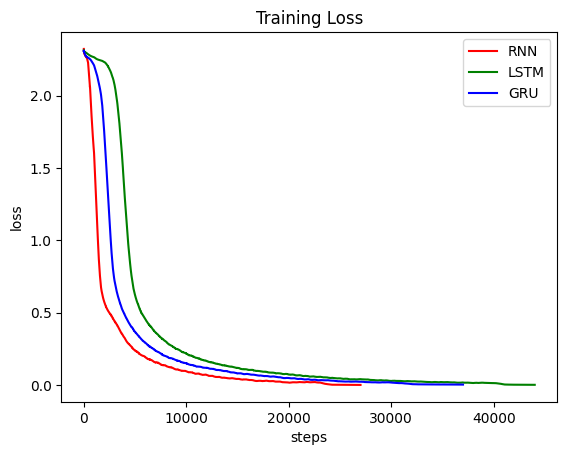

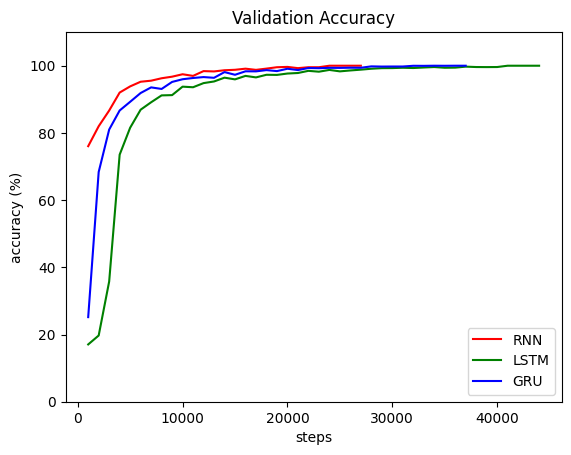

In [4]:
import numpy as np

names = tracer_dict.keys()
color_map = {
    "RNN" : "red",
    "LSTM" : "green", 
    "GRU" : "blue"
}

for name in names:
    trajectory = tracer_dict[name].trajectory()
    y = np.array(trajectory)
    x = np.linspace(1, len(trajectory), num=len(trajectory), dtype=np.uint32)
    plt.plot(x, y, color=color_map[name], label=name)

plt.title("Training Loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()

for name in names:
    accuracy = tracer_dict[name].accuracy()
    xx, yy = list(), list()
    for a, s in accuracy:
        xx.append(s)
        yy.append(a)
    plt.plot(xx, yy, color=color_map[name], label=name)

plt.title("Validation Accuracy")
plt.xlabel("steps")
plt.ylabel("accuracy (%)")
plt.ylim([0, 110])
plt.legend()
plt.show()

## Step5. 預測 HW2_MNIST_test.zip 的資料

In [5]:
import pandas as pd
import io

def get_best_result(bucket):
    orderlist = list()
    for idx, v in enumerate(bucket):
        if v > 0:
            orderlist.append((v, idx))
    random.shuffle(orderlist)
    orderlist = sorted(orderlist, reverse=True, key=lambda x: x[0])
    return orderlist[0][1]

for name, net in net_dict.items():
    net.eval()

loader = LazyLoader(TEST_DIR)
pred_result = list()

for _, (imgs, tgts, path) in enumerate(loader):
    filename = path[0][len(TEST_DIR)+1:] + ".png"
    pred_bucket = [0] * 10
    for name, net in net_dict.items():
        imgs = imgs.to(device)
        pred_bucket[net.get_max(imgs).cpu()[0].item()] += 1
    pred = get_best_result(pred_bucket)
    pred_result.append((filename, pred))
pred_result = sorted(pred_result, key=lambda x: x[0])

csv_result = "image,class\n"
for _, (filename, pred) in enumerate(pred_result):
    csv_result += "{},{}\n".format(filename, pred)

csv_result = csv_result[:-1]
df = pd.read_csv(io.StringIO(csv_result), sep=",", header=None)
print(df)

with open("HW4_prob1.csv", "w") as f:
    f.write(csv_result)

                 0      1
0            image  class
1      0000004.png      0
2      0000010.png      0
3      0000018.png      0
4      0000021.png      0
...            ...    ...
24346  0121727.png      9
24347  0121730.png      9
24348  0121736.png      9
24349  0121738.png      9
24350  0121739.png      9

[24351 rows x 2 columns]
